=== PARAMETROS ===
µ_photo = 0.0314 cm^-1
µ_compton = 0.2400 cm^-1
µ_total = 0.2714 cm^-1
lambda = 3.685 cm
t/lambda = 2.068

=== PROBABILIDADES ===
P(interaccion) = 0.8735
P(pasar sin interactuar) = 0.1265
P(foto|int) = 0.1155
P(compton|int) = 0.8845


=== SIMULACION SIN FWHM ===
Fotones simulados: 1000000
  Fotoelectricos: 100786 (10.08%)
  Compton: 772654 (77.27%)
  Sin interaccion: 126560 (12.66%)


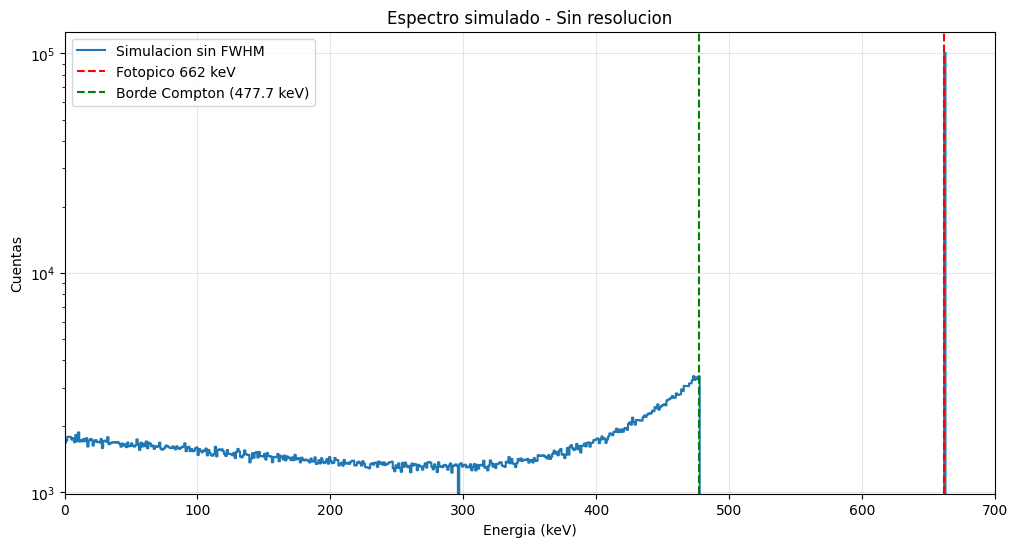

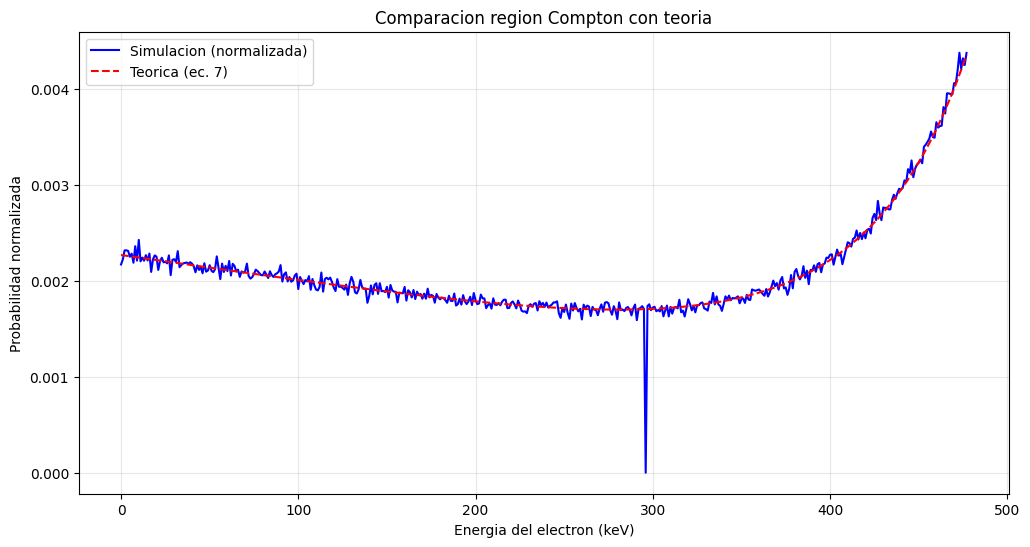


PUNTO 6: Espectro con FWHM vs Experimental (keV, a0=0, a1=1)

=== Simulacion con FWHM ===
Fotones simulados: 1000000
  Fotoelectricos: 100823 (10.08%)
  Compton: 772870 (77.29%)
  Sin interaccion: 126307 (12.63%)

Calibracion PUNTO 6: E(keV) = -56.0 + 1.0×canal

=== Inspeccion del archivo CSV ===
Primeras 5 lineas del archivo:
  Linea 0: canal,cuentas
  Linea 1: 1,0
  Linea 2: 2,0
  Linea 3: 3,0
  Linea 4: 4,0

Tiene encabezado? True → skiprows=1

Forma de los datos cargados: (4096, 2)
Primeras 5 filas:
[[1. 0.]
 [2. 0.]
 [3. 0.]
 [4. 0.]
 [5. 0.]]
Estructura: 2 columnas [canal, cuentas]

=== Resumen datos experimentales ===
Canales: 1 a 4096
Numero de canales: 4096
Total cuentas: 1421174
Maximo en canal 92: 5073.0 cuentas

=== Conversion a energia (Punto 6) ===
Primer canal → -55.0 keV
Ultimo canal → 4040.0 keV


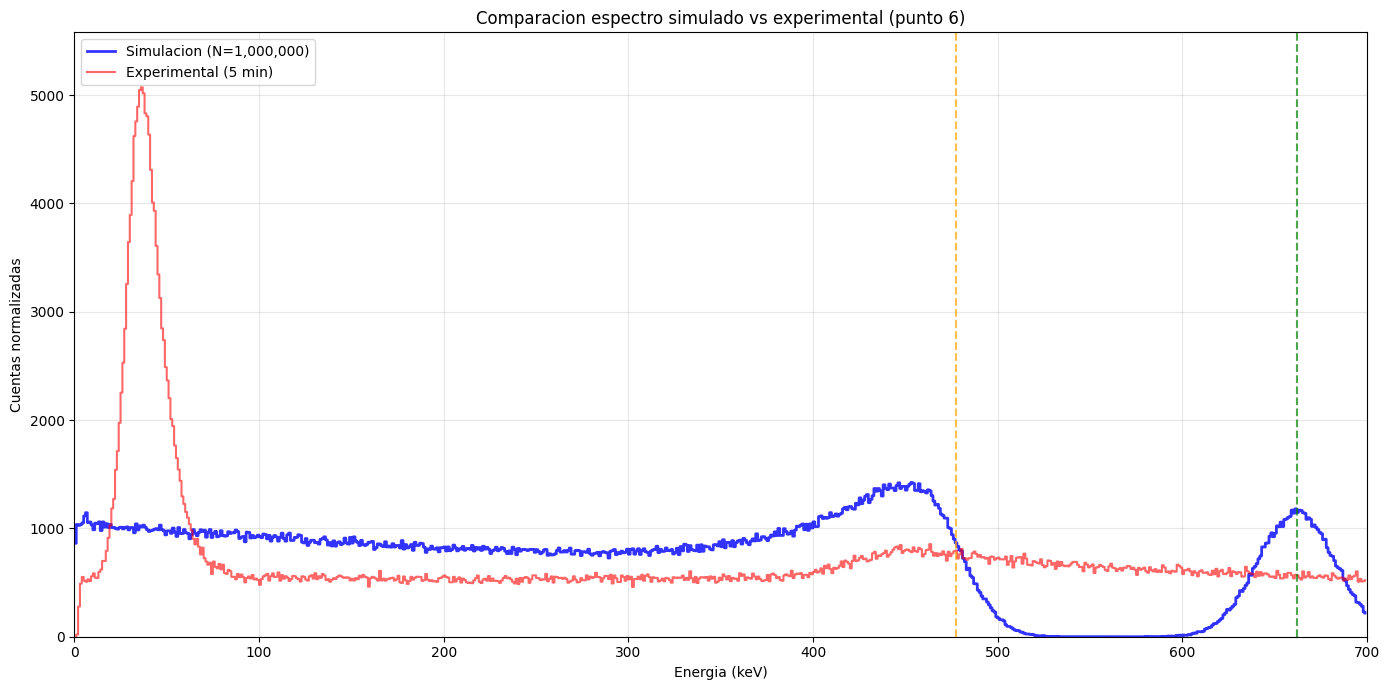


=== Analisis punto 6 ===
Min energia experimental: -55.0
Max energia experimental: 4040.0
Media energia experimental: 1992.5

=== Tu calibracion experimental ===
E(keV) = -53.0 + 3.191 * canal
Canal del fotopico: 224.1
Canal borde Compton: 166.3

Region Compton para normalizar: canales 47 a 110


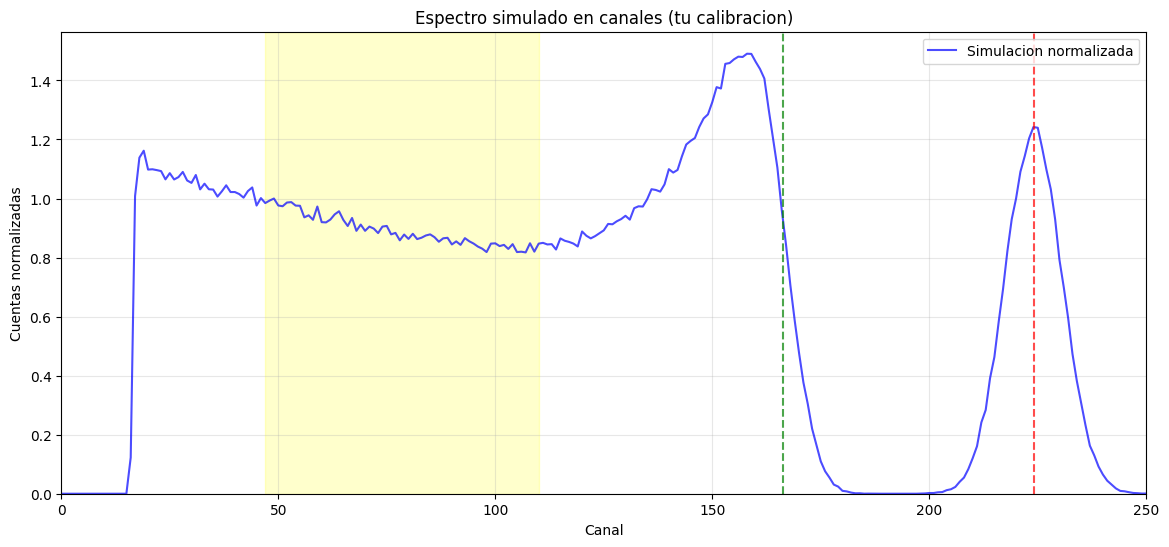


=== Tabla energia-canal ===
Energia (keV) | Canal
----------------------------------------
         0 |    16.6
        50 |    32.3
       100 |    47.9
       200 |    79.3
       300 |   110.6
       400 |   142.0
       500 |   173.3
       600 |   204.6
       662 |   224.1

=== Tabla coeficientes ===
mu_photo = 0.0314
mu_compton = 0.2400
mu_total = 0.2714

=== Geometria del detector ===
lambda = 3.685 cm
t/lambda = 2.068


In [1]:
# Simulacion de deteccion de fotones usando el modelo A. Esto es basicamente para ver como se comporta un detector NaI con Cs-137
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import requests
from io import StringIO

# Aqui van los parametros fisicos que uno puede ajustar si es necesario
E_gamma = 662.0  # keV de Cs-137
t = 7.62  # cm (3 pulgadas del cristal)

# Densidad del NaI. Esto deberias revisarlo si usas otro cristal
rho_NaI = 3.67  # g/cm^3

# Valores de la tabla NIST que yo meti manualmente
mu_rho_compton = 0.06540  # cm^2/g
mu_rho_photo = 0.008544   # cm^2/g
mu_rho_total = 0.07395    # cm^2/g

# Pasar los coeficientes a unidades lineales
mu_photo = mu_rho_photo * rho_NaI  # cm^-1
mu_compton = mu_rho_compton * rho_NaI  # cm^-1
mu_total = mu_photo + mu_compton

# Calculo del camino libre medio
lambda_total = 1.0 / mu_total
t_lambda = t / lambda_total

print("=== PARAMETROS ===")
print(f"µ_photo = {mu_photo:.4f} cm^-1")
print(f"µ_compton = {mu_compton:.4f} cm^-1")
print(f"µ_total = {mu_total:.4f} cm^-1")
print(f"lambda = {lambda_total:.3f} cm")
print(f"t/lambda = {t_lambda:.3f}")
print()

# Ahora calculo las probabilidades basicas del modelo A
P_int = 1.0 - np.exp(-mu_total * t)
P_no_int = np.exp(-mu_total * t)
P_photo_given_int = mu_photo / (mu_photo + mu_compton)
P_compton_given_int = mu_compton / (mu_photo + mu_compton)

print("=== PROBABILIDADES ===")
print(f"P(interaccion) = {P_int:.4f}")
print(f"P(pasar sin interactuar) = {P_no_int:.4f}")
print(f"P(foto|int) = {P_photo_given_int:.4f}")
print(f"P(compton|int) = {P_compton_given_int:.4f}")
print()

# Energia maxima del electron Compton (el famoso borde)
m_e = 511.0  # keV
E_max = (2 * E_gamma**2) / (m_e + 2 * E_gamma)

def compton_pdf(Ee):
    # Esta funcion es la expresion teorica de la ec. 7 para el electron Compton
    eps_e = Ee / E_gamma
    eps_gamma = E_gamma / m_e
    term1 = 2.0
    term2 = eps_e**2 / (eps_gamma**2 * (1 - eps_e)**2)
    term3 = (eps_e / (1 - eps_e)) * (eps_e - 2.0 / eps_gamma)
    return term1 + term2 + term3

# Discretizo la distribucion Compton para poder muestrear facil
n_channels_compton = int(E_max)
energies_e = np.linspace(0.1, E_max - 0.1, n_channels_compton)
pdf_values = compton_pdf(energies_e)
pdf_values = pdf_values / np.sum(pdf_values)
cdf_compton = np.cumsum(pdf_values)

def sample_compton_energy():
    # Hago un muestreo tipo CDF inversa: genero un numero aleatorio y busco donde cae
    u = np.random.random()
    idx = np.searchsorted(cdf_compton, u)
    return energies_e[idx]

# Funcion que devuelve el FWHM experimental segun el ajuste del laboratorio
def fwhm(E):
    # Esta ecuacion es el ajuste que obtuvimos en clase/lab: FWHM = -3.1 + 2.02*sqrt(E)
    intercept = -3.1
    slope = 2.02
    f_val = intercept + slope * np.sqrt(E)
    if f_val < 2.0:
        f_val = 2.0
    return f_val

def fwhm_uncertainty(E):
    # Si uno quiere meter la incertidumbre del FWHM, esta funcion devuelve el error propagado
    intercept_error = 0.3
    slope_error = 0.02
    return np.sqrt(intercept_error**2 + (slope_error * np.sqrt(E))**2)

def apply_resolution(E_deposited):
    # Aqui aplico la resolucion gaussiana al pico correspondiente
    sigma = fwhm(E_deposited) / 2.35
    return np.random.normal(E_deposited, sigma)

def apply_resolution_with_uncertainty(E_deposited):
    # Misma idea que arriba pero variando el FWHM segun su error estadistico
    fwhm_val = fwhm(E_deposited)
    fwhm_err = fwhm_uncertainty(E_deposited)
    fwhm_sampled = np.random.normal(fwhm_val, fwhm_err)
    if fwhm_sampled < 1.0:
        fwhm_sampled = 1.0
    sigma = fwhm_sampled / 2.35
    return np.random.normal(E_deposited, sigma)

def simulate_photons(N_photons, include_fwhm=False):
    # Esta funcion es el corazon de todo: simula fotones y registra energias depositadas
    energies_detected = []
    counts_photo = 0
    counts_compton = 0
    counts_none = 0

    for i in range(N_photons):
        # Reviso si el foton interactua
        if np.random.random() < P_int:
            # Si interactua reviso si es foto o compton
            if np.random.random() < P_photo_given_int:
                E_dep = E_gamma
                counts_photo += 1
            else:
                E_dep = sample_compton_energy()
                counts_compton += 1

            # Le aplico la resolucion si el usuario quiere
            if include_fwhm:
                E_dep = apply_resolution(E_dep)

            energies_detected.append(E_dep)
        else:
            # Si no interactua, simplemente lo cuento aparte
            counts_none += 1

    print(f"Fotones simulados: {N_photons}")
    print(f"  Fotoelectricos: {counts_photo} ({100*counts_photo/N_photons:.2f}%)")
    print(f"  Compton: {counts_compton} ({100*counts_compton/N_photons:.2f}%)")
    print(f"  Sin interaccion: {counts_none} ({100*counts_none/N_photons:.2f}%)")

    return np.array(energies_detected)

print("\n=== SIMULACION SIN FWHM ===")
N = 1000000
energies_no_fwhm = simulate_photons(N, include_fwhm=False)

bins = np.arange(0, 700, 1)
hist_no_fwhm, bin_edges = np.histogram(energies_no_fwhm, bins=bins)

plt.figure(figsize=(12, 6))
plt.step(bin_edges[:-1], hist_no_fwhm, where='post', label='Simulacion sin FWHM')
plt.xlabel('Energia (keV)')
plt.ylabel('Cuentas')
plt.title('Espectro simulado - Sin resolucion')
plt.axvline(E_gamma, color='r', linestyle='--', label='Fotopico 662 keV')
plt.axvline(E_max, color='g', linestyle='--', label=f'Borde Compton ({E_max:.1f} keV)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 700)
plt.yscale('log')
plt.show()

plt.figure(figsize=(12, 6))
compton_mask = (bin_edges[:-1] < E_max)
bin_centers = bin_edges[:-1][compton_mask]
hist_compton = hist_no_fwhm[compton_mask]
hist_norm = hist_compton / np.sum(hist_compton)
pdf_theoretical = compton_pdf(bin_centers)
pdf_theoretical = pdf_theoretical / np.sum(pdf_theoretical)

plt.plot(bin_centers, hist_norm, 'b-', label='Simulacion (normalizada)')
plt.plot(bin_centers, pdf_theoretical, 'r--', label='Teorica (ec. 7)')
plt.xlabel('Energia del electron (keV)')
plt.ylabel('Probabilidad normalizada')
plt.title('Comparacion region Compton con teoria')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n" + "="*60)
print("PUNTO 6: Espectro con FWHM vs Experimental (keV, a0=0, a1=1)")
print("="*60)

if 'energies_with_fwhm' not in locals():
    print("\n=== Simulacion con FWHM ===")
    energies_with_fwhm = simulate_photons(N, include_fwhm=True)

bins = np.arange(0, 701, 1)
hist_fwhm, bin_edges = np.histogram(energies_with_fwhm, bins=bins)

a0_p6 = -56.0
a1_p6 = 1.0

def channel_to_energy_p6(channel):
    # Esta funcion usa la calibracion simple del punto 6
    return a0_p6 + a1_p6 * channel

print(f"\nCalibracion PUNTO 6: E(keV) = {a0_p6} + {a1_p6}×canal")

try:
    print("\n=== Inspeccion del archivo CSV ===")
    with open('Cs137_5minNaI.csv', 'r') as f:
        primeras_lineas = [next(f) for _ in range(5)]
    print("Primeras 5 lineas del archivo:")
    for i, linea in enumerate(primeras_lineas):
        print(f"  Linea {i}: {linea.strip()}")

    import re
    primera_linea = primeras_lineas[0].strip()
    tiene_encabezado = not re.match(r'^[\\d\\s,.-]+$', primera_linea)
    skip_rows = 1 if tiene_encabezado else 0
    print(f"\nTiene encabezado? {tiene_encabezado} → skiprows={skip_rows}")

    data_exp = np.loadtxt('Cs137_5minNaI.csv', delimiter=',', skiprows=skip_rows)

    print(f"\nForma de los datos cargados: {data_exp.shape}")
    print(f"Primeras 5 filas:\n{data_exp[:5]}")

    num_columnas = data_exp.shape[1] if len(data_exp.shape) > 1 else 1

    if num_columnas == 1:
        print("Estructura: 1 columna (solo cuentas)")
        counts_exp_raw = data_exp.flatten()
        ch_exp_raw = np.arange(len(counts_exp_raw))
    elif num_columnas == 2:
        print("Estructura: 2 columnas [canal, cuentas]")
        ch_exp_raw = data_exp[:, 0]
        counts_exp_raw = data_exp[:, 1]
    else:
        print(f"Estructura: {num_columnas} columnas - usando primeras dos")
        ch_exp_raw = data_exp[:, 0]
        counts_exp_raw = data_exp[:, 1]

    ch_exp = ch_exp_raw.astype(int)
    counts_exp = counts_exp_raw

    print(f"\n=== Resumen datos experimentales ===")
    print(f"Canales: {ch_exp[0]} a {ch_exp[-1]}")
    print(f"Numero de canales: {len(ch_exp)}")
    print(f"Total cuentas: {np.sum(counts_exp):.0f}")
    print(f"Maximo en canal {ch_exp[np.argmax(counts_exp)]}: {np.max(counts_exp)} cuentas")

    print(f"\n=== Conversion a energia (Punto 6) ===")
    energies_exp_p6 = channel_to_energy_p6(ch_exp)

    print(f"Primer canal → {energies_exp_p6[0]:.1f} keV")
    print(f"Ultimo canal → {energies_exp_p6[-1]:.1f} keV")

    hist_exp_p6 = np.zeros(len(bin_edges) - 1)

    for energy, count in zip(energies_exp_p6, counts_exp):
        if 0 <= energy < 700:
            bin_idx = int(energy)
            if bin_idx < len(hist_exp_p6):
                hist_exp_p6[bin_idx] += count

    if np.sum(hist_exp_p6) == 0:
        print("WARNING: histograma experimental vacio tras convertir!")

    total_exp = np.sum(hist_exp_p6)
    total_sim = np.sum(hist_fwhm)

    if total_sim > 0 and total_exp > 0:
        norm_factor = total_exp / total_sim
        hist_fwhm_norm = hist_fwhm * norm_factor
    else:
        hist_fwhm_norm = hist_fwhm

    plt.figure(figsize=(14, 7))
    y_max = max(np.max(hist_fwhm_norm), np.max(hist_exp_p6)) * 1.1

    plt.step(bin_edges[:-1], hist_fwhm_norm, where='post',
             color='blue', alpha=0.8, linewidth=2, label=f'Simulacion (N={N:,})')

    plt.step(bin_edges[:-1], hist_exp_p6, where='post',
             color='red', alpha=0.6, linewidth=1.5, label='Experimental (5 min)')

    plt.axvline(E_gamma, color='green', linestyle='--', alpha=0.7, linewidth=1.5)
    plt.axvline(E_max, color='orange', linestyle='--', alpha=0.7, linewidth=1.5)

    plt.xlabel('Energia (keV)')
    plt.ylabel('Cuentas normalizadas')
    plt.title('Comparacion espectro simulado vs experimental (punto 6)')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 700)
    plt.ylim(0, y_max)
    plt.tight_layout()
    plt.show()

    print("\n=== Analisis punto 6 ===")
    print(f"Min energia experimental: {np.min(energies_exp_p6):.1f}")
    print(f"Max energia experimental: {np.max(energies_exp_p6):.1f}")
    print(f"Media energia experimental: {np.mean(energies_exp_p6):.1f}")

except FileNotFoundError:
    print("\nERROR: No se encontró 'Cs137_5minNaI.csv'")

except Exception as e:
    print("\nERROR procesando el archivo experimental:")
    print(e)

# Calibracion experimental real
a0 = -53.0
a1 = 3.191

a0_err = 6.0
a1_err = 0.025

def channel_to_energy(channel):
    # Convierte un canal a energia con tu calibracion final
    return a0 + a1 * channel

def energy_to_channel(energy):
    # La ecuacion inversa: energia -> canal
    return (energy - a0) / a1

channel_photopeak = energy_to_channel(E_gamma)
channel_compton_edge = energy_to_channel(E_max)

print("\n=== Tu calibracion experimental ===")
print(f"E(keV) = {a0} + {a1} * canal")
print(f"Canal del fotopico: {channel_photopeak:.1f}")
print(f"Canal borde Compton: {channel_compton_edge:.1f}")

channels_fwhm = energy_to_channel(energies_with_fwhm)
valid_mask = (channels_fwhm >= 0) & (channels_fwhm <= 800)
channels_fwhm_valid = channels_fwhm[valid_mask]
channels_int = np.round(channels_fwhm_valid).astype(int)

max_channel = 800
channel_counts = np.bincount(channels_int, minlength=max_channel+1)[:max_channel+1]

compton_start_ch = int(energy_to_channel(100))
compton_end_ch = int(energy_to_channel(300))

compton_start_ch = max(0, compton_start_ch)
compton_end_ch = min(max_channel, compton_end_ch)

print(f"\nRegion Compton para normalizar: canales {compton_start_ch} a {compton_end_ch}")

compton_region_counts = channel_counts[compton_start_ch:compton_end_ch+1]
if len(compton_region_counts) > 0:
    max_compton_sim = np.max(compton_region_counts)
    channel_counts_norm = channel_counts / max_compton_sim
else:
    channel_counts_norm = channel_counts / np.max(channel_counts)
    print("\nWARNING: region Compton muy pequena")

plt.figure(figsize=(14, 6))
channels_axis = np.arange(len(channel_counts_norm))

plt.plot(channels_axis, channel_counts_norm, 'b-', alpha=0.7, linewidth=1.5,
         label='Simulacion normalizada')

plt.axvline(channel_photopeak, color='r', linestyle='--', alpha=0.7)
plt.axvline(channel_compton_edge, color='g', linestyle='--', alpha=0.7)

plt.axvspan(compton_start_ch, compton_end_ch, alpha=0.2, color='yellow')

plt.xlabel('Canal')
plt.ylabel('Cuentas normalizadas')
plt.title('Espectro simulado en canales (tu calibracion)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 250)
plt.ylim(bottom=0)
plt.show()

print("\n=== Tabla energia-canal ===")
print("Energia (keV) | Canal")
print("-" * 40)
for E in [0, 50, 100, 200, 300, 400, 500, 600, 662]:
    print(f"{E:10.0f} | {energy_to_channel(E):7.1f}")

print("\n=== Tabla coeficientes ===")
print(f"mu_photo = {mu_photo:.4f}")
print(f"mu_compton = {mu_compton:.4f}")
print(f"mu_total = {mu_total:.4f}")

print("\n=== Geometria del detector ===")
print(f"lambda = {lambda_total:.3f} cm")
print(f"t/lambda = {t_lambda:.3f}")




=== DATOS EXPERIMENTALES ORIGINALES ===
Canales originales: 1 a 4096
Número de canales: 4096

Aplicando corrimiento de 1 canales...
Primer canal experimental: 1
Desplazando para que empiece en 0

=== DATOS EXPERIMENTALES DESPUÉS DE CORRIMIENTO ===
Canales desplazados: 0 a 800
Canales válidos (≤ 800): 801/4096

=== NORMALIZACIÓN EXPERIMENTAL ===
Región Compton: canales 47 a 110
Datos experimentales en región: 64 puntos
Máximo experimental en región Compton: 5073

=== FOTOPICO EXPERIMENTAL DETECTADO ===
Canal (desplazado): 111
Canal original: 112
Energía correspondiente: 301.2 keV
Valor normalizado: 0.304
FWHM aproximado: 52 canales
FWHM en energía: 165.9 keV


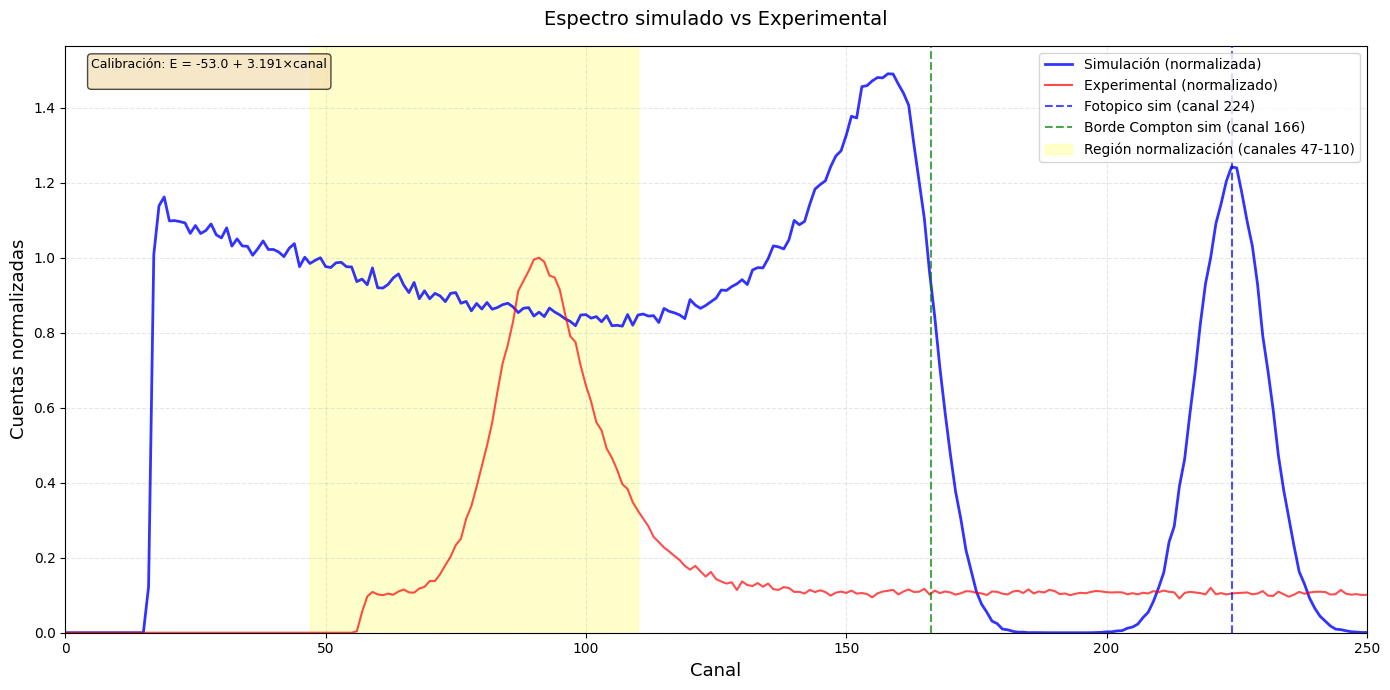


COMPARACIÓN CUANTITATIVA PUNTO 7

1. POSICIÓN DEL FOTOPICO:
   Simulado: canal 224 (662.0 keV)
   Experimental: canal 111 (original: 112)
   Experimental energía: 301.2 keV
   Δcanal (sim-exp): 113

2. VERIFICACIÓN ENERGÉTICA:
   Energía experimental calculada: 301.2 keV
   Diferencia con 662 keV: -360.8 keV

3. ALTURA RELATIVA DEL FOTOPICO:
   Simulado: 1.242
   Experimental: 0.304
   Relación sim/exp: 4.08


In [2]:
# Grafica del espectro simulado en canales (punto 7b) + datos experimentales con corrimiento
plt.figure(figsize=(14, 7))

# Eje de canales para la simulación
channels_axis = np.arange(len(channel_counts_norm))

# Grafico la simulación normalizada
plt.plot(channels_axis, channel_counts_norm, 'b-', alpha=0.8,
         linewidth=2, label='Simulación (normalizada)')

# Intento cargar los datos experimentales y alinearlos
try:
    # Cargo el archivo experimental
    data_exp = np.loadtxt('Cs137_5minNaI.csv', delimiter=',', skiprows=1)

    if data_exp.shape[1] >= 2:
        ch_exp_raw = data_exp[:, 0].astype(int)  # canales del experimento
        counts_exp_raw = data_exp[:, 1]          # cuentas medidas

        print(f"\n=== DATOS EXPERIMENTALES ORIGINALES ===")
        print(f"Canales originales: {ch_exp_raw[0]} a {ch_exp_raw[-1]}")
        print(f"Número de canales: {len(ch_exp_raw)}")

        # Aquí miro si toca correr los canales para que arranquen en 0
        min_channel_exp = np.min(ch_exp_raw)

        if min_channel_exp > 0:
            print(f"\nAplicando corrimiento de {min_channel_exp} canales...")
            print(f"Primer canal experimental: {min_channel_exp}")
            print(f"Desplazando para que empiece en 0")

            # Aplico el corrimiento
            ch_exp_shifted = ch_exp_raw - min_channel_exp
        else:
            ch_exp_shifted = ch_exp_raw.copy()

        # Evito que queden canales negativos
        ch_exp_shifted = np.maximum(ch_exp_shifted, 0)

        # Mantengo solo los datos que están dentro del rango simulado
        max_sim_channel = len(channels_axis) - 1
        valid_mask = (ch_exp_shifted <= max_sim_channel)

        ch_exp = ch_exp_shifted[valid_mask].astype(int)
        counts_exp = counts_exp_raw[valid_mask]

        print(f"\n=== DATOS EXPERIMENTALES DESPUÉS DE CORRIMIENTO ===")
        print(f"Canales desplazados: {ch_exp[0]} a {ch_exp[-1]}")
        print(f"Canales válidos (≤ {max_sim_channel}): {np.sum(valid_mask)}/{len(ch_exp_raw)}")

        # Normalizo el espectro experimental usando la región Compton
        mask_in_compton_region = (ch_exp >= compton_start_ch) & (ch_exp <= compton_end_ch)

        if np.any(mask_in_compton_region):
            exp_compton_counts = counts_exp[mask_in_compton_region]
            max_exp_compton = np.max(exp_compton_counts)

            print(f"\n=== NORMALIZACIÓN EXPERIMENTAL ===")
            print(f"Región Compton: canales {compton_start_ch} a {compton_end_ch}")
            print(f"Datos experimentales en región: {len(exp_compton_counts)} puntos")
            print(f"Máximo experimental en región Compton: {max_exp_compton:.0f}")

            if max_exp_compton > 0:
                counts_exp_norm = counts_exp / max_exp_compton

                # Grafico el experimental normalizado
                plt.plot(ch_exp, counts_exp_norm, 'r-', alpha=0.7,
                        linewidth=1.5, label='Experimental (normalizado)')

                # Busco fotopico experimental
                photopeak_region_mask = (ch_exp > compton_end_ch) & (ch_exp < max_sim_channel)

                if np.any(photopeak_region_mask):
                    photopeak_ch_exp = ch_exp[photopeak_region_mask][np.argmax(counts_exp_norm[photopeak_region_mask])]
                    photopeak_val_exp = np.max(counts_exp_norm[photopeak_region_mask])

                    print(f"\n=== FOTOPICO EXPERIMENTAL DETECTADO ===")
                    print(f"Canal (desplazado): {photopeak_ch_exp}")
                    print(f"Canal original: {photopeak_ch_exp + min_channel_exp}")
                    print(f"Energía correspondiente: {channel_to_energy(photopeak_ch_exp):-.1f} keV")
                    print(f"Valor normalizado: {photopeak_val_exp:.3f}")

                    # Aquí calculo el FWHM aproximado
                    half_max = photopeak_val_exp / 2
                    peak_idx = np.where(ch_exp == photopeak_ch_exp)[0][0]

                    left_idx = peak_idx
                    while left_idx > 0 and counts_exp_norm[left_idx] > half_max:
                        left_idx -= 1

                    right_idx = peak_idx
                    while right_idx < len(counts_exp_norm)-1 and counts_exp_norm[right_idx] > half_max:
                        right_idx += 1

                    fwhm_channels = ch_exp[right_idx] - ch_exp[left_idx]
                    print(f"FWHM aproximado: {fwhm_channels} canales")
                    print(f"FWHM en energía: {fwhm_channels * a1:.1f} keV")

                else:
                    print("¡ADVERTENCIA: No se encontró fotopico experimental en el rango!")
            else:
                print("¡ADVERTENCIA: Máximo experimental en región Compton es cero!")
                counts_exp_norm = counts_exp / np.max(counts_exp)
                plt.plot(ch_exp, counts_exp_norm, 'r-', alpha=0.7,
                        linewidth=1.5, label='Experimental (normalizado al máximo total)')
        else:
            print(f"¡ADVERTENCIA: No hay datos experimentales en la región de normalización!")
            print(f"Región buscada: canales {compton_start_ch} a {compton_end_ch}")
            print(f"Canales experimentales disponibles: {ch_exp[0]} a {ch_exp[-1]}")

            if len(counts_exp) > 0:
                counts_exp_norm = counts_exp / np.max(counts_exp)
                plt.plot(ch_exp, counts_exp_norm, 'r-', alpha=0.7,
                        linewidth=1.5, label='Experimental (normalizado al máximo total)')
    else:
        print("¡ERROR: Formato de archivo experimental incorrecto!")

except FileNotFoundError:
    print("\n¡ADVERTENCIA: Archivo experimental no encontrado para Punto 7")
    print("Mostrando solo simulación...")

except Exception as e:
    print(f"\n¡ERROR al cargar datos experimentales para Punto 7: {e}")
    import traceback
    traceback.print_exc()

# Aquí agrego algunas líneas guía para comparar posiciones características del espectro
plt.axvline(channel_photopeak, color='blue', linestyle='--',
            alpha=0.7, linewidth=1.5, label=f'Fotopico sim (canal {channel_photopeak:.0f})')
plt.axvline(channel_compton_edge, color='green', linestyle='--',
            alpha=0.7, linewidth=1.5, label=f'Borde Compton sim (canal {channel_compton_edge:.0f})')

# Marco la región que usé para normalizar
plt.axvspan(compton_start_ch, compton_end_ch, alpha=0.2,
            color='yellow', label=f'Región normalización (canales {compton_start_ch}-{compton_end_ch})')

# Cosas básicas de la gráfica
plt.xlabel('Canal', fontsize=13)
plt.ylabel('Cuentas normalizadas', fontsize=13)
plt.title('Espectro simulado vs Experimental', fontsize=14, pad=15)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')

plt.xlim(0, 250)
plt.ylim(bottom=0)

# Un recuadro con la calibración que estamos usando
calib_text = f'Calibración: E = {a0:.1f} + {a1:.3f}×canal\n'

plt.text(0.02, 0.98, calib_text,
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),
         fontsize=9)

plt.tight_layout()
plt.savefig('punto7b_comparacion_canales_desplazado.png', dpi=300, bbox_inches='tight')
plt.show()

# Finalmente hago unas comparaciones numéricas entre simulado y experimental
try:
    if 'counts_exp_norm' in locals() and 'photopeak_ch_exp' in locals():
        print("\n" + "="*60)
        print("COMPARACIÓN CUANTITATIVA PUNTO 7")
        print("="*60)

        print(f"\n1. POSICIÓN DEL FOTOPICO:")
        print(f"   Simulado: canal {channel_photopeak:.0f} ({channel_to_energy(channel_photopeak):.1f} keV)")
        print(f"   Experimental: canal {photopeak_ch_exp} (original: {photopeak_ch_exp + min_channel_exp})")
        print(f"   Experimental energía: {channel_to_energy(photopeak_ch_exp):.1f} keV")
        print(f"   Δcanal (sim-exp): {channel_photopeak - photopeak_ch_exp:.0f}")

        energy_exp = channel_to_energy(photopeak_ch_exp)
        print(f"\n2. VERIFICACIÓN ENERGÉTICA:")
        print(f"   Energía experimental calculada: {energy_exp:.1f} keV")
        print(f"   Diferencia con 662 keV: {energy_exp - 662:.1f} keV")

        if channel_photopeak < len(channel_counts_norm):
            sim_photopeak_value = channel_counts_norm[int(channel_photopeak)]
            print(f"\n3. ALTURA RELATIVA DEL FOTOPICO:")
            print(f"   Simulado: {sim_photopeak_value:.3f}")
            print(f"   Experimental: {photopeak_val_exp:.3f}")
            print(f"   Relación sim/exp: {sim_photopeak_value/photopeak_val_exp:.2f}")

except NameError:
    print("\nNo se pudieron calcular estadísticas comparativas")
